# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [2]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [5]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [6]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [7]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.40104663051541484


In [8]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


In [9]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


# 以降にコードを追加

In [10]:
from sklearn import preprocessing

# 外れ値確認と除去

In [11]:
winefea_df = wine_quality_df[feature_names]
winequa_df = pd.DataFrame(wine_quality_df["quality"])
q1 = winefea_df.quantile(0.25)
q3 = winefea_df.quantile(0.75)
iqr = q3 - q1
#外れ値基準
qmax = q3 + 1.5 * iqr
qmin = q1 - 1.5 * iqr
#外れ値をNanに
dfa = winefea_df[(winefea_df > qmin) & (winefea_df < qmax)]
#Nanを含む行を削除(winefea_df更新)
winefea_df = dfa.dropna(axis=0,how="any")
#winequa_dfも外れ値の行を削除で更新
winequa_df = winequa_df.iloc[winefea_df.index.values]
winefea_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


# 正規化

In [12]:
mms = preprocessing.MinMaxScaler()
winefea_df_mms = pd.DataFrame(mms.fit_transform(winefea_df), 
                                   columns=winefea_df.columns)
winefea_df_mms.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.319444,0.655367,0.000000,0.291667,0.448718,0.25,0.243478,0.630058,0.770270,0.353846,0.148936
1,0.375000,0.858757,0.000000,0.583333,0.730769,0.60,0.530435,0.514451,0.351351,0.538462,0.234043
2,0.375000,0.723164,0.054795,0.458333,0.653846,0.35,0.417391,0.537572,0.432432,0.492308,0.234043
3,0.847222,0.180791,0.767123,0.291667,0.435897,0.40,0.469565,0.653179,0.297297,0.384615,0.234043
4,0.319444,0.655367,0.000000,0.291667,0.448718,0.25,0.243478,0.630058,0.770270,0.353846,0.148936


# モデル訓練

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(winefea_df_mms, np.ravel(winequa_df), 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((833, 11), (357, 11))

In [14]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.34728873 0.36472583 0.43207102 0.35026898 0.31009353]
Average score: 0.36088961817876575
Test score: 0.37185240984154155


In [15]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.4491018  0.47305389 0.50898204 0.40361446 0.5       ]
Average score: 0.4669504364764447
Test score: 0.4341736694677871


In [16]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.35173962 0.39063402 0.45188493 0.33254143 0.36757173]
Average score: 0.37887434454707203
Test score: 0.34343270059538866


# ハイパーパラメータの調節

SVCのmseが他2つと比べ高い値なのでハイパーパラメータを調節する。
コストCとRBFカーネルgammaの2つを調節する。

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid={"C":[0.001,0.01,0.1,1,10,100],
            "gamma":[0.001,0.01,0.1,1,10,100]
           }
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.6610644257703081

In [19]:
grid_search.best_params_

{'C': 1, 'gamma': 10}

In [20]:
svm_clf = SVC(C=1, gamma=10, random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.44311377 0.49101796 0.49101796 0.40963855 0.42771084]
Average score: 0.4524998196378327
Test score: 0.43137254901960786


わずかにスコアは良くなった。

In [21]:
param_grid={"C":[0.3,0.7,1,3,7],
            "gamma":[3,7,10,30,70]
           }
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 3, 'gamma': 7}

In [22]:
param_grid={"C":[2,3,4,5,6],
            "gamma":[4,5,6,7,8,9]
           }
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 2, 'gamma': 8}

In [23]:
svm_clf = SVC(C=2, gamma=8, kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.41916168 0.49101796 0.49700599 0.48795181 0.43975904]
Average score: 0.4669792944232018
Test score: 0.43137254901960786


細かく調節したがスコア変化はない。

# 学習曲線

In [24]:
from sklearn.model_selection import learning_curve

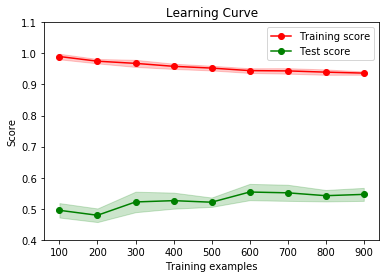

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    svm_clf, winefea_df_mms, np.ravel(winequa_df), cv=kfold, 
    train_sizes=np.arange(100, 901, 100), random_state=0, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Traing score と Test score をプロット
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# 標準偏差の範囲を色付け
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

plt.ylim(0.4, 1.1)
plt.legend(loc="best")

plt.show()

図を見る限り過学習と読み取れる。

# 特徴量厳選

In [26]:
from sklearn.feature_selection import SelectKBest

In [27]:
select = SelectKBest(k=7)
select .fit(winefea_df_mms, np.ravel(winequa_df))
mask_df = pd.DataFrame(select.get_support())
winefeacol_df = pd.DataFrame(winefea_df.columns)
pd.concat([winefeacol_df, mask_df], axis=1)

,0,0
0,fixed acidity,False
1,volatile acidity,True
2,citric acid,True
3,residual sugar,False
4,chlorides,True
5,free sulfur dioxide,False
6,total sulfur dioxide,True
7,density,True
8,pH,False
9,sulphates,True


In [28]:
winefea_df_select = winefea_df_mms.iloc[:,mask_df[mask_df[0]].index]
winefea_df_select.head()

,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol
0,0.655367,0.000000,0.448718,0.243478,0.630058,0.353846,0.148936
1,0.858757,0.000000,0.730769,0.530435,0.514451,0.538462,0.234043
2,0.723164,0.054795,0.653846,0.417391,0.537572,0.492308,0.234043
3,0.180791,0.767123,0.435897,0.469565,0.653179,0.384615,0.234043
4,0.655367,0.000000,0.448718,0.243478,0.630058,0.353846,0.148936


In [29]:
feature_names = list(np.copy(winefea_df_select.columns))

In [30]:
X_train, X_test, y_train, y_test = \
    train_test_split(winefea_df_select, np.ravel(winequa_df), 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((833, 7), (357, 7))

In [31]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.41916168 0.49700599 0.50898204 0.41566265 0.46385542]
Average score: 0.46093355457759183
Test score: 0.43137254901960786


特徴量を7つに絞ると、ハイパーパラメータを調節した時のスコアと同じになったが、
7つ以外の場合のスコアは悪かった。

特徴量を7つに絞った状態でハイパーパラメータの最適化をしてみる。

In [32]:
param_grid={"C":[0.01,0.1,1,10],
            "gamma":[0.01,0.1,1,10,100]
           }
grid_search2 = GridSearchCV(SVC(random_state=0), param_grid, cv=kfold)
grid_search2.fit(X_train, y_train)
grid_search2.score(X_test, y_test)

0.6330532212885154

In [33]:
grid_search2.best_params_

{'C': 1, 'gamma': 10}

In [34]:
svm_clf = SVC(C=1, gamma=10, kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.37125749 0.47904192 0.54491018 0.45783133 0.48192771]
Average score: 0.4669937233965803
Test score: 0.45098039215686275


特徴量選択とハイパーパラメータの調節を組み合わせたが、スコアは向上しなかった。

# Lasso回帰

In [35]:
from sklearn.linear_model import Lasso

In [36]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

X_train, X_test, y_train, y_test = \
    train_test_split(winefea_df_mms, np.ravel(winequa_df), 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((833, 11), (357, 11))

In [37]:
lasso = Lasso()
cross_validation(lasso)

Cross-Validation scores: [0.56372172 0.54649357 0.62152583 0.65075872 0.56803609]
Average score: 0.5901071845770126
Test score: 0.5699888598896942


In [38]:
#alpha値を最適にする
param_grid={"alpha":[0.00001,0.0001,0.001,0.01,0.1,1,10,100]}
grid_search = GridSearchCV(Lasso(), param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)
grid_search.best_params_

{'alpha': 0.001}

In [39]:
lasso = Lasso(alpha=0.001)
cross_validation(lasso)

Cross-Validation scores: [0.34708036 0.36719994 0.43039898 0.34931329 0.31024132]
Average score: 0.3608467764574593
Test score: 0.37035000593455536


最適化するとスコアは大幅に向上した。

# SVRのハイパーパラメータ最適化

外れ値の除去、正規化時点でスコアの高かったSVRのハイパーパラメータの最適化を行い、さらに良いスコアとなるか見てみる。

In [40]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.35173962 0.39063402 0.45188493 0.33254143 0.36757173]
Average score: 0.37887434454707203
Test score: 0.34343270059538866


In [41]:
param_grid={"C":[0.01,0.1,1,10],
            "gamma":[0.01,0.1,1,10],
            "epsilon":[0.0001,0.001,0.01,0.1,1,10]
           }
grid_search = GridSearchCV(SVR(kernel="rbf"), param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)
grid_search.best_params_

{'C': 1, 'epsilon': 0.001, 'gamma': 0.1}

In [42]:
svm_reg = SVR(C=1, epsilon=0.001, gamma=0.1)
cross_validation(svm_reg)

Cross-Validation scores: [0.33198434 0.3689508  0.43023517 0.34920104 0.32214313]
Average score: 0.3605028963827298
Test score: 0.3737685724694509


トレーニングスコアはよくなったが、テストスコアが悪くなった。